# Entry to the invasive species monitoring Competition

This notebook contains the whole process of a submission to this [competition](https://www.kaggle.com/c/invasive-species-monitoring)

In [1]:
%matplotlib inline

In [1]:
# Create directories to use later
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/species-monitoring/'

In [6]:
from numpy.random import random, permutation
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras import backend
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

backend.set_image_dim_ordering('tf')

## Time to organize the data

In [9]:
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/lucasarb/Documents/fast-ai/courses/deeplearning1/nbs/data/species-monitoring


In [10]:
#Create the validation from the training dataset
%cd $DATA_HOME_DIR/train

/home/lucasarb/Documents/fast-ai/courses/deeplearning1/nbs/data/species-monitoring/train


In [14]:
from glob import glob
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [15]:
from shutil import copyfile

g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [16]:
%cd $DATA_HOME_DIR/valid

/home/lucasarb/Documents/fast-ai/courses/deeplearning1/nbs/data/species-monitoring/valid


In [17]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

## Separate classse into different directory

In [18]:
# Create the folders invasive(c1) and non-invasive(c0)

%cd $DATA_HOME_DIR/sample/train
%mkdir c0
%mkdir c1

%cd $DATA_HOME_DIR/sample/valid
%mkdir c0
%mkdir c1

%cd $DATA_HOME_DIR/valid
%mkdir c0
%mkdir c1

%cd $DATA_HOME_DIR/train
%mkdir c0
%mkdir c1

/home/lucasarb/Documents/fast-ai/courses/deeplearning1/nbs/data/species-monitoring/sample/train
/home/lucasarb/Documents/fast-ai/courses/deeplearning1/nbs/data/species-monitoring/sample/valid
/home/lucasarb/Documents/fast-ai/courses/deeplearning1/nbs/data/species-monitoring/valid
/home/lucasarb/Documents/fast-ai/courses/deeplearning1/nbs/data/species-monitoring/train


In [34]:
#create a list of filenames to put in the c1(invasive) folder
import pandas as pd

labels = pd.read_csv('train_labels.csv')
invasive = labels[labels['invasive'] == 1]
invasive = invasive.drop(['invasive'], axis = 1)
invasive['name'] = invasive['name'].apply(lambda x: str(x)+'.jpg')
invasive.to_csv('filenames.csv', header=False, index=False)

In [39]:
from shutil import move
# Divide the images into different directories
%cd $DATA_HOME_DIR/sample/train

for fname in open('../../filenames.csv').read().split():
    if os.path.isfile(fname):
        move(fname,'c1/')
        
%mv *.jpg c0/
#------------------------------
%cd $DATA_HOME_DIR/sample/valid

for fname in open('../../filenames.csv').read().split():
    if os.path.isfile(fname):
        move(fname,'c1/')
        
%mv *.jpg c0/
#------------------------------
%cd $DATA_HOME_DIR/valid

for fname in open('../filenames.csv').read().split():
    if os.path.isfile(fname):
        move(fname,'c1/')
        
%mv *.jpg c0/
#------------------------------
%cd $DATA_HOME_DIR/train

for fname in open('../filenames.csv').read().split():
    if os.path.isfile(fname):
        move(fname,'c1/')
        
%mv *.jpg c0/

In [45]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/lucasarb/Documents/fast-ai/courses/deeplearning1/nbs/data/species-monitoring/test


## Creating the VGG model from scratch
In this part I will generate the VGG16 model by compiling a keras models for it

In [4]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Conv2D(filters,(3,3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

The VGG16 model had the images in BGR and the average subtracted. Now, we need to change it to be like this.

In [5]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # revert axis 

Now it is time to create the model

In [6]:
def VGG16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape = (3,224,224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [7]:
#create the model
model = VGG16()

In [8]:
#get the pre-trained weights
fpath = get_file('vgg16.h5',
                 'http://files.fast.ai/models/vgg16.h5',
                 cache_subdir='models')
model.load_weights(fpath)

### Finetuning the network

In [21]:
%pwd

'/home/lucasarb/Documents/fast-ai/courses/deeplearning1/nbs'

In [13]:
batch_size = 8

In [111]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(DATA_HOME_DIR+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

Found 2095 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


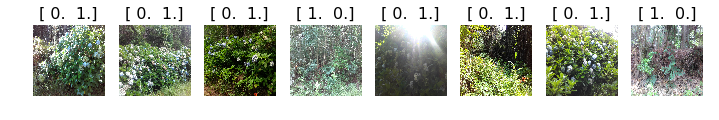

In [110]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid',batch_size=batch_size)
imgs,labels = next(batches)

from utils import plots
plots(imgs, titles=labels)

In [18]:
from keras.optimizers import SGD, RMSprop, Adam

def finetune(model, batches):
    model.pop()
    for layer in model.layers: layer.trainable = False
    model.add(Dense(batches.num_class,activation='softmax'))
    
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    # sort the classes by index
    classes = list(iter(batches.class_indices))
    
    for c in batches.class_indices:
        classes[batches.class_indices[c]] = c
        
    model.classes = classes

In [19]:
# Fine tune the model
finetune(model,batches)

In [25]:
def vgg_fit(model, batches, val_batches, epochs = 1):
    model.fit_generator(batches,
                    steps_per_epoch=batches.samples//batches.batch_size+1,
                    epochs=epochs,
                    validation_steps=val_batches.samples//val_batches.batch_size+1)

In [26]:
weights_filename = None
n_epochs = 3
results_dir = 'results/'

for epoch in range(n_epochs):
    print("Running epoch: %d" % epoch)
    vgg_fit(model, batches, val_batches, epochs = 1)
    latest_weights_filename = 'ft{}.h5'.format(epoch)
    model.save_weights(DATA_HOME_DIR+results_dir+latest_weights_filename)
print("Completed %s fit operations" % n_epochs)

Running epoch: 0
Epoch 1/1
262/262 [==============================] - 79s - loss: 0.5318 - acc: 0.8196    
Running epoch: 1
Epoch 1/1
262/262 [==============================] - 57s - loss: 0.4400 - acc: 0.8563    
Running epoch: 2
Epoch 1/1
262/262 [==============================] - 51s - loss: 0.4930 - acc: 0.8501    


NameError: name 'no_of_epochs' is not defined

In [27]:
vgg.model.load_weights(DATA_HOME_DIR+results_dir+'ft2d.h5')

Completed 3 fit operations


In [30]:
def get_test_batches(dirname, gen=image.ImageDataGenerator(), shuffle=False, 
                     batch_size=8, class_mode=None):
    return gen.flow_from_directory(DATA_HOME_DIR+dirname,
                                   target_size=(224,224),
                                   class_mode=class_mode,
                                   shuffle=shuffle,
                                   batch_size=batch_size)

test_batches = get_test_batches('test')

Found 1531 images belonging to 1 classes.


In [31]:
predictions = model.predict_generator(test_batches, test_batches.samples//test_batches.batch_size + 1)

In [36]:
# test_batches.filenames has the filenames and predictions has the predictions
import bcolz

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

save_array(DATA_HOME_DIR+results_dir + 'test_preds1.dat', predictions)
save_array(DATA_HOME_DIR+results_dir + 'filenames1.dat', test_batches.filenames)

In [66]:
val_pred = model.predict_generator(val_batches, val_batches.samples//val_batches.batch_size)

In [68]:
expected_labels = val_batches.classes
val_isInvasive = val_pred[:,1]
val_isInvasive = np.round(val_isInvasive)

print(val_isInvasive.shape)

(200,)


In [69]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(expected_labels,val_isInvasive)

In [75]:
print(predictions[:5])
print(test_batches.filenames[:5])


[[  1.6304e-08   1.0000e+00]
 [  7.4276e-05   9.9993e-01]
 [  9.9878e-01   1.2227e-03]
 [  9.9936e-01   6.3580e-04]
 [  9.9988e-01   1.1741e-04]]
['unknown/1305.jpg', 'unknown/751.jpg', 'unknown/1178.jpg', 'unknown/71.jpg', 'unknown/315.jpg']


In [104]:
isInvasive = predictions[:,1]
isInvasive = isInvasive.clip(min=0.02, max=0.98)
filenames = test_batches.filenames

In [105]:
import re

numbers = re.compile('\d+(?:\.\d+)?')

In [106]:
name = []
for file in filenames:
    name.append(numbers.findall(file))

In [107]:
import pandas as pd

df = pd.DataFrame({'name':name,
                   'invasive':isInvasive})
df = df[['name','invasive']]
df['name'] = df['name'].apply(lambda x: ''.join(x))
df.head()

,name,invasive
0,1305,0.98
1,751,0.98
2,1178,0.02
3,71,0.02
4,315,0.02


In [108]:
df.to_csv(DATA_HOME_DIR+'submissions/submission3.csv',index=False)